In [5]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from keras.preprocessing.image import ImageDataGenerator

In [6]:
#Parameters
 
path = "myData" # folder with all the class folders
labelFile = 'labels.csv' # file with all names of classes
batch_size_val=50  
steps_per_epoch_val=2000
epochs_val=10
imageDimesions = (32,32,3)
testRatio = 0.2    
validationRatio = 0.2 

In [7]:
# Importing of the Images
count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:",len(myList))
noOfClasses=len(myList)
print("Importing Classes.....")
for x in range (0,len(myList)):
    myPicList = os.listdir(path+"/"+str(count))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(count)+"/"+y)
        images.append(curImg)
        classNo.append(count)
    print(count, end =" ")
    count +=1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


In [8]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)
 

In [9]:
# TO CHECK IF NUMBER OF IMAGES MATCHES TO NUMBER OF LABELS FOR EACH DATA SET
print("Data Shapes")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
print("Test",end = "");print(X_test.shape,y_test.shape)
assert(X_train.shape[0]==y_train.shape[0]), "The number of images in not equal to the number of lables in training set"
assert(X_validation.shape[0]==y_validation.shape[0]), "The number of images in not equal to the number of lables in validation set"
assert(X_test.shape[0]==y_test.shape[0]), "The number of images in not equal to the number of lables in test set"
assert(X_train.shape[1:]==(imageDimesions))," The dimesions of the Training images are wrong "
assert(X_validation.shape[1:]==(imageDimesions))," The dimesionas of the Validation images are wrong "
assert(X_test.shape[1:]==(imageDimesions))," The dimesionas of the Test images are wrong"

Data Shapes
Train(22271, 32, 32, 3) (22271,)
Validation(5568, 32, 32, 3) (5568,)
Test(6960, 32, 32, 3) (6960,)


In [10]:
# READ CSV FILE
data=pd.read_csv(labelFile)
print("data shape ",data.shape,type(data))

data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


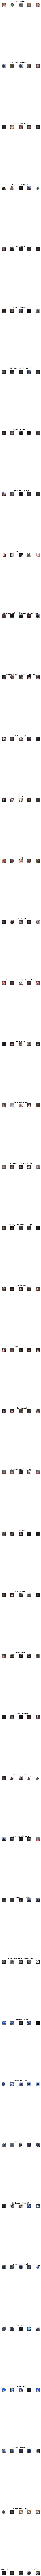

In [11]:
# DISPLAY SOME SAMPLES IMAGES  OF ALL THE CLASSES
num_of_samples = []
cols = 5
num_classes = noOfClasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 300))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)- 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+ "-"+row["Name"])
            num_of_samples.append(len(x_selected))

[124, 1281, 1306, 775, 1131, 1067, 244, 817, 813, 841, 1139, 767, 1194, 1220, 418, 345, 245, 643, 679, 123, 202, 162, 217, 296, 153, 864, 350, 138, 302, 170, 230, 447, 134, 399, 240, 678, 203, 117, 1155, 174, 187, 139, 142]


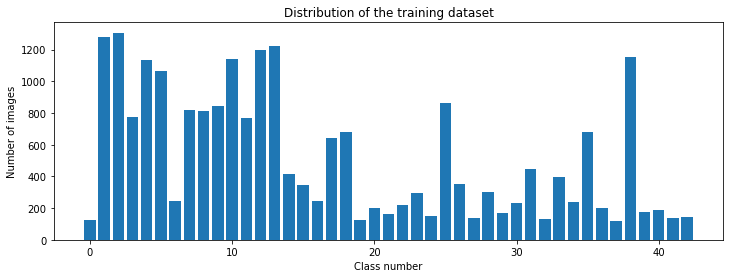

In [12]:
# DISPLAY A BAR CHART SHOWING NO OF SAMPLES FOR EACH CATEGORY
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [13]:
# PREPROCESSING THE IMAGES
 
def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img =cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)     
    img = equalize(img)      
    img = img/255            
    return img
 
X_train=np.array(list(map(preprocessing,X_train)))  
X_validation=np.array(list(map(preprocessing,X_validation)))
X_test=np.array(list(map(preprocessing,X_test)))
cv2.imshow("GrayScale Images",X_train[random.randint(0,len(X_train)-1)]) 

In [14]:
# ADD A DEPTH OF 1
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

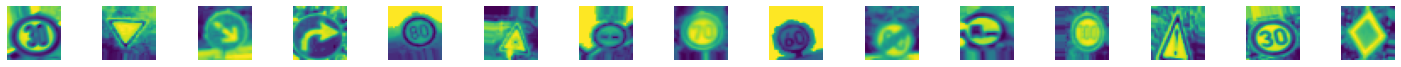

In [15]:
# AUGMENTATAION OF IMAGES: TO MAKEIT MORE GENERIC
dataGen= ImageDataGenerator(width_shift_range=0.1,  
                            height_shift_range=0.1,
                            zoom_range=0.2,  
                            shear_range=0.1,  
                            rotation_range=10) 
dataGen.fit(X_train)
batches= dataGen.flow(X_train,y_train,batch_size=20) 
X_batch,y_batch = next(batches)
 
# TO SHOW AGMENTED IMAGE SAMPLES
fig,axs=plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimesions[0],imageDimesions[1]))
    axs[i].axis('off')
plt.show()
 
 
y_train = to_categorical(y_train,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)

In [16]:
# CONVOLUTION NEURAL NETWORK MODEL
def myModel():
    no_Of_Filters=60
    size_of_Filter=(5,5) 
                     
    size_of_Filter2=(3,3)
    size_of_pool=(2,2)  
    no_Of_Nodes = 500   
    model= Sequential()
    model.add((Conv2D(no_Of_Filters,size_of_Filter,input_shape=(imageDimesions[0],imageDimesions[1],1),activation='relu')))  
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
 
    model.add((Conv2D(no_Of_Filters//2, size_of_Filter2,activation='relu')))
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))
 
    model.add(Flatten())
    model.add(Dense(no_Of_Nodes,activation='relu'))
    model.add(Dropout(0.5)) 
    model.add(Dense(noOfClasses,activation='softmax'))
    # COMPILE MODEL
    model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [17]:
############################### TRAIN
model = myModel()
print(model.summary())
history=model.fit_generator(dataGen.flow(X_train,y_train,batch_size=batch_size_val),steps_per_epoch=steps_per_epoch_val,epochs=epochs_val,validation_data=(X_validation,y_validation),shuffle=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxP

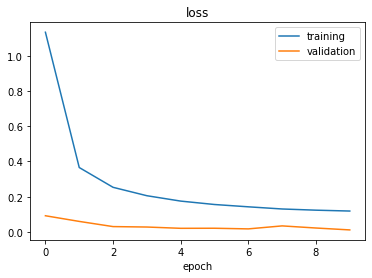

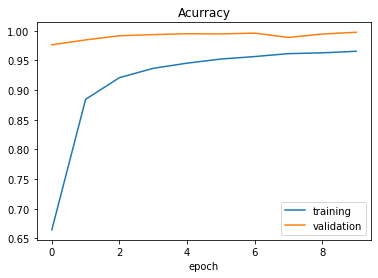

Test Score: 0.014648667890110798
Test Accuracy: 0.9961206896551724


In [20]:
# PLOT
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score =model.evaluate(X_test,y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])

In [ ]:
# STORE MODEL AS A PICKLE OBJECT
pickle_out= open("model_trained_3.p","wb")  
pickle.dump(model,pickle_out)
pickle_out.close()
cv2.waitKey(0)

In [34]:
import tensorflow as tf
import tensorflow.keras as keras
import sys
#import keras
import keras.backend as K
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Embedding, Dropout, Input, Concatenate

print("Python: "+str(sys.version))
print("Tensorflow version: "+tf.__version__)
print("Keras version: "+keras.__version__)

Python: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Tensorflow version: 2.3.0
Keras version: 2.4.0
